# Overview

In this notebook, we generate synthetic low-rank outcome data and test different ways of learning the utility model:
- fit indepdendent GPs to each outcome
- learn a PCA decomposition, fit independent GPs to the top principal components that explain most variance
- learn a PCA decomposition, select top PCs that explain the utility, fit independent GPs to them

Look at two test cases here:
- outcome dimensionality = 20, rank = 1
- outcome dimensionality = 20, rank = 2; utility depends on the less dominant axis

Test case 1 helps us answer the question: Does PCA do better than Indep? Is it because it's easier to learn the PCA matrix than the independent GP hyperparameters?

Test case 2 helps us compare PCA and PCR. We expect PCR to do better than PCA in this case.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor

from test_problems.synthetic_problem import generate_principal_axes, PCATestProblem
from src.transforms import (
    generate_random_projection,
    InputCenter,
    LinearProjectionInputTransform,
    LinearProjectionOutcomeTransform,
    PCAInputTransform,
    PCAOutcomeTransform,
    SubsetOutcomeTransform,
)
from src.pref_learning_helpers import gen_initial_real_data, fit_pref_model
from src.diagnostics import check_util_model_fit
from src.models import make_modified_kernel

# import botorch, gpytorch functions
from botorch import fit_gpytorch_model, fit_gpytorch_mll
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.optim.utils import _filter_kwargs
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import ChainedOutcomeTransform, Standardize
from botorch.models.transforms.input import (
    ChainedInputTransform,
    FilterFeatures,
    Normalize,
)

from gpytorch.kernels import MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

warnings.filterwarnings("ignore")


/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Test case 1: outcome dimensionality = 20, rank = 1

In [3]:
config = {
    "input_dim": 1,
    "outcome_dim": 20,
    "latent_dim": 1,
    "PC_noise_level": 0,
    "noise_std": 0.1,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([1]*20),
    "PC_lengthscales": [0.1],
    "PC_scaling_factors": [2],
    "variance_explained_threshold": 0.99,
}

torch.manual_seed(1234)

ground_truth_principal_axes = config['ground_truth_principal_axes'].unsqueeze(0)

initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

In [4]:
class LinearUtil(torch.nn.Module):
    def __init__(self, beta: torch.Tensor):
        """
        Args:
            beta: size `output_dim` tensor
        """
        super().__init__()
        self.register_buffer("beta", beta)

    def calc_raw_util_per_dim(self, Y):
        return Y * self.beta.to(Y)

    def forward(self, Y, X=None):
        return Y @ self.beta.to(Y)

class SumOfSquaresUtil(torch.nn.Module):
    def __init__(self, beta: torch.Tensor):
        """
        Args:
            beta: size `output_dim` tensor
        """
        super().__init__()
        self.register_buffer("beta", beta)

    def calc_raw_util_per_dim(self, Y):
        return torch.square(Y) * self.beta.to(Y)

    def forward(self, Y, X=None):
        return torch.square(Y) @ self.beta.to(Y)

In [7]:
torch.manual_seed(123)

beta = torch.tensor([1]*config["outcome_dim"], **tkwargs)
util_func = LinearUtil(beta=beta)

train_X, train_Y, util_vals, comps = gen_initial_real_data(n=100, problem=problem, util_func=util_func)

# train_Y = train_Y - torch.mean(train_Y, dim = 0)

In [8]:
train_X.shape, train_Y.shape

(torch.Size([100, 1]), torch.Size([100, 20]))

In [9]:
st_model = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll = ExactMarginalLogLikelihood(st_model.likelihood, st_model)
fit_gpytorch_model(st_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [12]:
options = {"maxiter": 1000}

pca_model = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(config["outcome_dim"], min_stdv=100),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll = ExactMarginalLogLikelihood(pca_model.likelihood, pca_model)

fit_gpytorch_mll(pca_mll)

print(pca_model.outcome_transform['pca'].axes_learned)

tensor([[0.2239, 0.2215, 0.2233, 0.2244, 0.2242, 0.2232, 0.2233, 0.2231, 0.2243,
         0.2244, 0.2222, 0.2231, 0.2247, 0.2244, 0.2236, 0.2227, 0.2239, 0.2237,
         0.2233, 0.2247]], dtype=torch.float64)


In [403]:
def helper(num_test_points, models_dict, outcome_idxs):

    test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)
    test_Y = problem.eval_metrics_true(test_X).detach()

    for outcome_idx in outcome_idxs:

        for model_name, model in models_dict.items():

            test_Y_posterior_mean = model.posterior(test_X).mean[:, outcome_idx]
           
            print(model_name, 'outcome', outcome_idx, 'RMSE', torch.sqrt(torch.mean(torch.square(test_Y_posterior_mean - test_Y[:,outcome_idx]))).item())



In [22]:
pca_axes_dict = {
    "learned": pca_model.outcome_transform['pca'].axes_learned,
    "true": ground_truth_principal_axes # TODO: normalize
}
# TODO: later, run regression and add PCR_axes_dict for the rank-2 test case

In [31]:
def fit_util_models(train_Y, comps, util_vals, input_transform, covar_module):
    util_model = fit_pref_model(
        train_Y, 
        comps, 
        input_transform = input_transform, 
        covar_module = covar_module
    )
    util_model_oracle = SingleTaskGP(
        train_Y, 
        util_vals.unsqueeze(1), 
        input_transform = input_transform, 
        covar_module = covar_module
    )
    mll = ExactMarginalLogLikelihood(util_model_oracle.likelihood, util_model_oracle)
    fit_gpytorch_mll(mll)

    return util_model, util_model_oracle

def fit_models_helper(train_Y, comps, util_vals, method, axes_dict = None, modify_kernel = False):

    input_transform = None
    models_dict = {}
    if method in ("pca", "pcr"):
        for axes_label, axes in axes_dict.items():
            latent_dim = axes.shape[0]
            input_transform = ChainedInputTransform(
                        **{
                            "center": InputCenter(config["outcome_dim"]),
                            "pca": PCAInputTransform(axes.to(torch.double)),
                        }
                    )
            covar_module = make_modified_kernel(ard_num_dims=latent_dim) if modify_kernel else None

            util_model, util_model_oracle = fit_util_models(
                train_Y, comps, util_vals, input_transform, covar_module)
            models_dict[method+'_'+axes_label] = util_model
            models_dict[method+'_'+axes_label+'_oracle'] = util_model_oracle
    
    elif method == "st":
        covar_module = make_modified_kernel(ard_num_dims=train_Y.shape[-1]) if modify_kernel else None
        input_transform = None
        util_model, util_model_oracle = fit_util_models(
                train_Y, comps, util_vals, input_transform, covar_module)
        models_dict[method] = util_model
        models_dict[method+'_oracle'] = util_model_oracle
    
    return models_dict

In [32]:
pca_models_dict = fit_models_helper(
    train_Y, comps, util_vals, 
    method="pca", 
    axes_dict = pca_axes_dict, 
    modify_kernel = True
)

In [34]:
pca_models_dict.keys()

dict_keys(['pca_learned', 'pca_learned_oracle', 'pca_true', 'pca_true_oracle'])

In [35]:
st_models_dict = fit_models_helper(
    train_Y, comps, util_vals, 
    method="st", 
    # axes_dict = pca_axes_dict, 
    # modify_kernel = True
)

In [36]:
st_models_dict.keys()

dict_keys(['st', 'st_oracle'])

In [40]:
def check_util_model_fit_wrapper(models_dict, seed = 0):
    torch.manual_seed(seed)
    acc_dict = {}
    for model_key, model in models_dict.items():
        acc = check_util_model_fit(
            pref_model = model,
            problem = problem,
            util_func = util_func,
            n_test = 1000,
            batch_eval = True,
            return_util_vals = False
        )
        acc_dict[model_key] = acc
    
    return acc_dict

In [41]:
check_util_model_fit_wrapper(pca_models_dict)

{'pca_learned': 0.9660000205039978,
 'pca_learned_oracle': 0.9380000233650208,
 'pca_true': 0.9319999814033508,
 'pca_true_oracle': 0.949999988079071}

In [42]:
check_util_model_fit_wrapper(st_models_dict)

{'st': 0.8899999856948853, 'st_oracle': 0.9879999756813049}

In [ ]:
# Next TODO:

# look at nonlinear utility
# math derivation
# PCR

# Test case 2: outcome dimensionality = 20, rank = 2

In [438]:
config = {
    "input_dim": 1,
    "outcome_dim": 20,
    "latent_dim": 1,
    "PC_noise_level": 0,
    "noise_std": 0.1,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([1]*20),
    "PC_lengthscales": [0.1],
    "PC_scaling_factors": [2],
    "variance_explained_threshold": 0.99,
}

torch.manual_seed(1234)

ground_truth_principal_axes = config['ground_truth_principal_axes'].unsqueeze(0)

initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

use_modified_kernel = False

In [439]:
torch.manual_seed(123)

beta = torch.tensor([1]*config["outcome_dim"], **tkwargs)
util_func = LinearUtil(beta=beta)

train_X, train_Y, util_vals, comps = gen_initial_real_data(n=100, problem=problem, util_func=util_func)


In [440]:
train_Y.shape, util_vals.shape, comps.shape

(torch.Size([100, 20]), torch.Size([100]), torch.Size([50, 2]))

In [441]:
st_model_low = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll_low = ExactMarginalLogLikelihood(st_model_low.likelihood, st_model_low)
fit_gpytorch_mll(st_mll_low)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [442]:
options = {"maxiter": 1000}

pca_model_low = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(config["outcome_dim"], min_stdv=100),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll_low = ExactMarginalLogLikelihood(pca_model_low.likelihood, pca_model_low)

# train PCA model and log training stats
# fit_gpytorch_scipy(pca_mll, options=options)
fit_gpytorch_mll(pca_mll_low)

print(pca_model_low.outcome_transform['pca'].axes_learned)

tensor([[0.2239, 0.2215, 0.2233, 0.2244, 0.2242, 0.2232, 0.2233, 0.2231, 0.2243,
         0.2244, 0.2222, 0.2231, 0.2247, 0.2244, 0.2236, 0.2227, 0.2239, 0.2237,
         0.2233, 0.2247]], dtype=torch.float64)


In [443]:
use_modified_kernel = True

pca_covar_module = None
if use_modified_kernel:
    pca_covar_module = make_modified_kernel(ard_num_dims = 1)


pca_util_model = fit_pref_model(
    train_Y, 
    comps, 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model_low.outcome_transform['pca'].axes_learned),
                    }
                ),
    covar_module = pca_covar_module
)

pca_util_model_oracle = SingleTaskGP(
    train_Y, 
    util_vals.unsqueeze(1), 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model_low.outcome_transform['pca'].axes_learned),
                    }
                ),
    covar_module = pca_covar_module
)

mll = ExactMarginalLogLikelihood(pca_util_model_oracle.likelihood, pca_util_model_oracle)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
    (input_transform): ChainedInputTransform(
      (center): InputCenter()
      (pca): PCAInputTransform()
    )
  )
)

In [450]:
use_modified_kernel = True

st_covar_module = None
if use_modified_kernel:
    st_covar_module = make_modified_kernel(ard_num_dims = 20)

st_util_model = fit_pref_model(
    train_Y, 
    comps, 
    # input_transform=Normalize(config["outcome_dim"])
    covar_module = st_covar_module
)

st_util_model_oracle = SingleTaskGP(
    train_Y, 
    util_vals.unsqueeze(1), 
    covar_module = st_covar_module
)

mll = ExactMarginalLogLikelihood(st_util_model_oracle.likelihood, st_util_model_oracle)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): GreaterThan(1.000E-04)
      )
      (outputscale_prior): SmoothedBoxPrior()
      (raw_outputscale_constraint): Interval(2.000E-01, 5.000E+00)
    )
  )
)

In [448]:
torch.manual_seed(0)
test_util_vals_pca, pred_util_vals_pca, util_acc_pca = check_util_model_fit(
    pref_model = pca_util_model,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('pca util accuracy: ', util_acc_pca)

test_util_vals_pca_oracle, pred_util_vals_pca_oracle, util_acc_pca_oracle = check_util_model_fit(
    pref_model = pca_util_model_oracle,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('pca oracle util accuracy: ', util_acc_pca_oracle)

pca util accuracy:  0.9660000205039978
pca oracle util accuracy:  0.9380000233650208


In [451]:
torch.manual_seed(0)
test_util_vals_st, pred_util_vals_st, util_acc_st = check_util_model_fit(
    pref_model = st_util_model,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('ST util accuracy: ', util_acc_st)

test_util_vals_st_oracle, pred_util_vals_st_oracle, util_acc_st_oracle = check_util_model_fit(
    pref_model = st_util_model_oracle,
    problem=problem,
    util_func=util_func,
    n_test=1000,
    batch_eval=True,
    return_util_vals = True
)
print('st oracle util accuracy: ', util_acc_st_oracle)

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.

mean difference in relative error of utility prediction -0.005132338271812821
SD of difference in relative error of utility prediction 1.5979983156094808


Text(0.5, 1.0, 'difference in relative error of predicted test utility values')

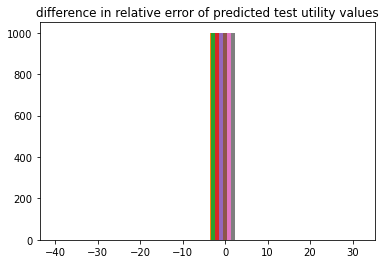

In [377]:
print(
    'mean difference in relative error of utility prediction', 
    torch.mean((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).item()
)

print(
    'SD of difference in relative error of utility prediction', 
    torch.std((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).item()
)

plt.hist(((pred_util_vals_st_oracle - pred_util_vals_pca_oracle)/test_util_vals_st).detach().numpy())
plt.title('difference in relative error of predicted test utility values')